# Método de Hartree-Fock para a Molécula de H<sub>2</sub> usando Base STO-nG

Autor: [Prof. Elvis do A. Soares](https://github.com/elvissoares) 

Contato: [elvis@peq.coppe.ufrj.br](mailto:elvis@peq.coppe.ufrj.br) - [Programa de Engenharia Química, PEQ/COPPE, UFRJ, Brasil](https://www.peq.coppe.ufrj.br/)

---

## Equação de Roothan-Hartree-Fock

$$F c = e S c$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.special import gamma, gammainc

# import scienceplots
# plt.style.use(['notebook'])

In [2]:
class GTO():
    def __init__(self, alpha, c, R):
        self.alpha = alpha
        self.c = c
        self.R = R
        self.norm = np.power(2 * alpha / np.pi, 0.75)

In [3]:
#----------------------------------------------------------------------
# Basis Set Exchange
# Version 0.11
# https://www.basissetexchange.org
#----------------------------------------------------------------------
#   Basis set: STO-3G
# Description: STO-3G Minimal Basis (3 functions/AO)
#        Role: orbital
#     Version: 1  (Data from Gaussian09)
#----------------------------------------------------------------------


# BASIS "ao basis" SPHERICAL PRINT
# #BASIS SET: (3s) -> [1s]
# H    S
#       0.3425250914E+01       0.1543289673E+00
#       0.6239137298E+00       0.5353281423E+00
#       0.1688554040E+00       0.4446345422E+00
# END

In [4]:
class Orbital():
    def __init__(self, name, alpha, coeff, R):
        self.name = name
        self.alpha = alpha
        self.coeff = coeff
        self.R = R
        self.basis = [GTO(alpha=a, c=c, R=self.R) for a, c in zip(self.alpha, self.coeff)]

    def __repr__(self):
        return f"Orbital({self.name}, {self.alpha}, {self.coeff}, {self.R})"

In [5]:
class H_atom():
    def __init__(self, R):
        self.R = np.array(R)
        self.orbitals = []
        self.Z = 1  # Atomic number for Hydrogen

    def add_orbital(self, name, alpha=None, coeff=None):
        orbital = Orbital(name = name, alpha=alpha, coeff=coeff, R=self.R)
        self.orbitals.append(orbital)

    def set_basis_set(self, basis_set):
        self.basis_set = basis_set
        # For Hydrogen atom
        if self.basis_set == 'STO-2G':
            # STO-3G basis set for Hydrogen
            # Source: https://www.basissetexchange.org
            self.add_orbital(name='1s',alpha= [0.1309756377E+01,0.2331359749E+00], coeff=[0.4301284983E+00,0.6789135305E+00])

        elif self.basis_set == 'STO-3G':
            # STO-3G basis set for Hydrogen
            # Source: https://www.basissetexchange.org
            self.add_orbital(name='1s',alpha= [0.3425250914E+01, 0.6239137298E+00, 0.1688554040E+00], coeff=[0.1543289673E+00, 0.5353281423E+00, 0.4446345422E+00])

        elif self.basis_set == 'STO-6G':
            # STO-6G basis set for Hydrogen
            # Source: https://www.basissetexchange.org
            self.add_orbital(name='1s',alpha= [0.3552322122E+02,0.6513143725E+01,0.1822142904E+01,0.6259552659E+00,0.2430767471E+00,0.1001124280E+00], coeff=[0.9163596281E-02,0.4936149294E-01,0.1685383049E+00,0.3705627997E+00,0.4164915298E+00,0.1303340841E+00])

    def __repr__(self):
        return f"H Atom at {self.R} in a.u"

In [6]:
Ha = H_atom(R=[0.0, 0.0, 0.0])
Hb = H_atom(R=[1.4, 0.0, 0.0])

In [7]:
Ha, Hb

(H Atom at [0. 0. 0.] in a.u, H Atom at [1.4 0.  0. ] in a.u)

In [8]:
Ha.set_basis_set('STO-3G')
Hb.set_basis_set('STO-3G')

In [9]:
Ha.orbitals, Hb.orbitals

([Orbital(1s, [3.425250914, 0.6239137298, 0.168855404], [0.1543289673, 0.5353281423, 0.4446345422], [0. 0. 0.])],
 [Orbital(1s, [3.425250914, 0.6239137298, 0.168855404], [0.1543289673, 0.5353281423, 0.4446345422], [1.4 0.  0. ])])

In [10]:
# overlap
def overlap(molecule):
    # Calcula todos os orbitais da molécula
    orbitals = [orbital for atom in molecule for orbital in atom.orbitals]
    # Inicializa a matriz de sobreposição S
    S_matrix = np.zeros((len(orbitals), len(orbitals)))
    for a, orbital_a in enumerate(orbitals):
        for b, orbital_b in enumerate(orbitals):
            Rdiff = np.linalg.norm(orbital_a.R - orbital_b.R)
            # Calculate the overlap integral for each pair of basis functions
            # S_ij = ∫ φ_i(r) φ_j(r) dτ
            # where φ_i and φ_j are the basis functions
            # Here we assume spherical harmonics, so we can use the norm of the basis functions
            # The norm is already calculated in GTO class
            for basis_a in orbital_a.basis:
                for basis_b in orbital_b.basis:
                    norm = basis_a.norm * basis_b.norm
                    p = basis_a.alpha + basis_b.alpha
                    q = basis_a.alpha * basis_b.alpha/ p
                    # The overlap integral for Gaussian-type orbitals
                    S_integral = norm * np.exp(-q * Rdiff**2) * (np.pi / p)**1.5
                    S_matrix[a, b] +=  basis_a.c * basis_b.c * S_integral
    return S_matrix

In [11]:
my_molecule = [Ha, Hb]

for a, atom_a in enumerate(my_molecule):
    print(a, atom_a.orbitals)

0 [Orbital(1s, [3.425250914, 0.6239137298, 0.168855404], [0.1543289673, 0.5353281423, 0.4446345422], [0. 0. 0.])]
1 [Orbital(1s, [3.425250914, 0.6239137298, 0.168855404], [0.1543289673, 0.5353281423, 0.4446345422], [1.4 0.  0. ])]


In [12]:
overlap(my_molecule)

array([[1.        , 0.65931821],
       [0.65931821, 1.        ]])

In [13]:
def kinetic(molecule):
    orbitals = [orbital for atom in molecule for orbital in atom.orbitals]
    T_matrix = np.zeros((len(orbitals), len(orbitals)))
    for a, orbital_a in enumerate(orbitals):
        for b, orbital_b in enumerate(orbitals):
            Rdiff = np.linalg.norm(orbital_a.R - orbital_b.R)
            for basis_a in orbital_a.basis:
                for basis_b in orbital_b.basis:
                    norm = basis_a.norm * basis_b.norm
                    p = basis_a.alpha + basis_b.alpha
                    q = basis_a.alpha * basis_b.alpha / p
                    # Kinetic energy integral for Gaussian-type orbitals
                    T_integral = norm * basis_a.c * basis_b.c * np.exp(-q * Rdiff**2) * (np.pi / p)**1.5

                    P = basis_a.alpha * orbital_a.R + basis_b.alpha * orbital_b.R
                    Pp = P/p 
                    PG = Pp - orbital_b.R
                    PGx2 = PG[0]*PG[0]
                    PGy2 = PG[1]*PG[1]
                    PGz2 = PG[2]*PG[2]

                    T_matrix[a, b] += 3 * basis_b.alpha * T_integral
                    T_matrix[a, b] -= 2 * basis_b.alpha **2 * T_integral * (PGx2 + 0.5/p)
                    T_matrix[a, b] -= 2 * basis_b.alpha **2 * T_integral * (PGy2 + 0.5/p)
                    T_matrix[a, b] -= 2 * basis_b.alpha **2 * T_integral * (PGz2 + 0.5/p)
    return T_matrix

In [14]:
kinetic(my_molecule)

array([[0.76003188, 0.23645466],
       [0.23645466, 0.76003188]])

In [15]:
def boys(x,n):
    if x == 0:
        return 1.0 / (2 * n + 1)
    else:
        return (1.0 / (2 * x ** (n+0.5))) * gammainc(n+0.5,x) * gamma(n+0.5)

def electron_nuclear_attraction(molecule):
    orbitals = [orbital for atom in molecule for orbital in atom.orbitals]
    V_matrix = np.zeros((len(orbitals), len(orbitals)))
    for atom in molecule:
        for a, orbital_a in enumerate(orbitals):
            for b, orbital_b in enumerate(orbitals):
                Rdiff = np.linalg.norm(orbital_a.R - orbital_b.R)
                for basis_a in orbital_a.basis:
                    for basis_b in orbital_b.basis:
                        norm = basis_a.norm * basis_b.norm
                        p = basis_a.alpha + basis_b.alpha
                        q = basis_a.alpha * basis_b.alpha / p

                        P = basis_a.alpha * orbital_a.R + basis_b.alpha * orbital_b.R
                        Pp = P/p 
                        PG = Pp - atom.R
                        PG2 = np.dot(PG, PG)
                        # Electron-nuclear attraction integral for Gaussian-type orbitals
                        V_integral = norm * basis_a.c * basis_b.c * np.exp(-q * Rdiff**2) * (2.0*np.pi / p)
                        V_matrix[a, b] += - atom.Z * V_integral * boys(p*PG2,0)
    return V_matrix

In [16]:
electron_nuclear_attraction(my_molecule)

array([[-1.88044089, -1.19483462],
       [-1.19483462, -1.88044089]])

In [17]:
def electron_electron_repulsion(molecule):
    orbitals = [orbital for atom in molecule for orbital in atom.orbitals]
    V_matrix = np.zeros((len(orbitals), len(orbitals),len(orbitals), len(orbitals)))
    for a, orbital_a in enumerate(orbitals):
        for b, orbital_b in enumerate(orbitals):
            Rab = np.linalg.norm(orbital_a.R - orbital_b.R)
            for c, orbital_c in enumerate(orbitals):
                for d, orbital_d in enumerate(orbitals):
                    Rcd = np.linalg.norm(orbital_c.R - orbital_d.R)
                    for basis_a in orbital_a.basis:
                        for basis_b in orbital_b.basis:
                            for basis_c in orbital_c.basis:
                                for basis_d in orbital_d.basis:
                                    norm = basis_a.norm * basis_b.norm * basis_c.norm * basis_d.norm 
                                    coeff = basis_a.c * basis_b.c * basis_c.c * basis_d.c
                                    pab = basis_a.alpha + basis_b.alpha
                                    pcd = basis_c.alpha + basis_d.alpha
                                    qab = basis_a.alpha * basis_b.alpha / pab
                                    qcd = basis_c.alpha * basis_d.alpha / pcd

                                    Pab = basis_a.alpha * orbital_a.R + basis_b.alpha * orbital_b.R
                                    Pcd = basis_c.alpha * orbital_c.R + basis_d.alpha * orbital_d.R
                                    Ppab = Pab/pab
                                    Ppcd = Pcd/pcd
                                    PpabPpcd = Ppab - Ppcd
                                    PpabPpcd2 = np.dot(PpabPpcd, PpabPpcd)/(1.0/pab + 1.0/pcd)

                                    # Integral de repulsão eletrônica para orbitais tipo Gaussianos
                                    V_integral = norm * coeff * 2.0 * np.pi**2 / (pab * pcd)
                                    V_integral *= np.sqrt(np.pi / (pab + pcd))
                                    V_integral *= np.exp(-qab * Rab**2 - qcd * Rcd**2)
                                    V_matrix[a, b, c, d] +=  V_integral * boys(PpabPpcd2,0)
    return V_matrix

In [18]:
electron_electron_repulsion(my_molecule)

array([[[[0.77460594, 0.44410766],
         [0.44410766, 0.56967593]],

        [[0.44410766, 0.29702854],
         [0.29702854, 0.44410766]]],


       [[[0.44410766, 0.29702854],
         [0.29702854, 0.44410766]],

        [[0.56967593, 0.44410766],
         [0.44410766, 0.77460594]]]])

In [19]:
def nuclear_nuclear_repulsion(molecule):
    # Calcula a repulsão nuclear entre os núcleos dos átomos na molécula
    V = 0.0
    for a in range(len(molecule)):
        for b in range(a + 1, len(molecule)):
            R = np.linalg.norm(molecule[a].R - molecule[b].R)
            V += molecule[a].Z * molecule[b].Z / R
    return V

In [20]:
nuclear_nuclear_repulsion(my_molecule)

np.float64(0.7142857142857143)

In [21]:
def compute_G(density_matrix, Vee):
    nbasis = density_matrix.shape[0]
    G = np.zeros((nbasis, nbasis))
    for a in range(nbasis):
        for b in range(nbasis):
            for c in range(nbasis):
                for d in range(nbasis):
                    rho = density_matrix[c, d]
                    J = Vee[a, b, c, d]
                    K = Vee[a, d, b, c]
                    G[a, b] += rho * (J - 0.5 * K)
    return G

def compute_density_matrix(mos):
    nbasis_functions = mos.shape[0]
    density_matrix = np.zeros((nbasis_functions, nbasis_functions))
    # D = occ * C * C^T
    for i in range(nbasis_functions):
        for j in range(nbasis_functions):
            density_matrix[i, j] += 2 * mos[i] * mos[j]  # Assuming all orbitals are doubly occupied
    return density_matrix

In [ ]:
def scf(molecule, max_iter=100, tol=1e-6):
    S = overlap(molecule)
    T = kinetic(molecule)
    Ven = electron_nuclear_attraction(molecule)
    Vee = electron_electron_repulsion(molecule)
    Vnn = nuclear_nuclear_repulsion(molecule)

    # Inicializa a matriz de coeficientes
    D = np.zeros(S.shape)

    # 1. Entra no loop de iteração para o método SCF
    for _ in range(max_iter):

        # 2. Calcula a matriz Fock
        G = compute_G(D,Vee)
        F = T + Ven + G

        # 3. Resolve o problema de autovalores
        S_inv = linalg.inv(S)
        S_inv_half = linalg.sqrtm(S_inv)
        # transforma matriz de Fock para a base ortonormal
        F_ortho = np.dot(S_inv_half, np.dot(F, S_inv_half))
        # Resolve o problema de autovalores na base ortonormal
        eigvals, eigvecs = linalg.eigh(F_ortho)
        # Calcula orbitais moleculares na base original
        mos = np.dot(S_inv_half, eigvecs)

        # 4. Forma a nova matriz de densidade
        D_new = compute_density_matrix(mos[:,0])

        # 5. Verifica a convergência
        if np.linalg.norm(D_new - D) < tol:
            break

        D = D_new

    E_total = np.trace(np.dot(D, F-0.5*G)) + Vnn
    return E_total, D

In [23]:
Ha = H_atom(R=[0.0, 0.0, 0.0])
Hb = H_atom(R=[1.4, 0.0, 0.0])

Ha.set_basis_set('STO-2G')
Hb.set_basis_set('STO-2G')

my_molecule = [Ha, Hb]

Rarray = np.arange(0.5, 5.0, 0.005)
Earray_2G = np.zeros_like(Rarray)

for i, R in enumerate(Rarray):
    Ha.R = np.array([0.0, 0.0, 0.0])
    Hb.R = np.array([R, 0.0, 0.0])
    
    scf_energy, density_matrix = scf(my_molecule)
    Earray_2G[i] = scf_energy

Text(0.5, 1.0, 'Energia da molécula de H2')

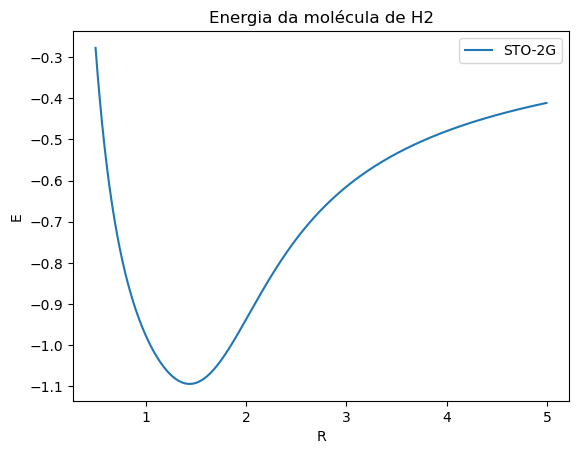

In [24]:
plt.plot(Rarray, Earray_2G, label = 'STO-2G')
plt.legend(loc='upper right')
plt.xlabel('R')
plt.ylabel('E') 
plt.title('Energia da molécula de H2')

In [25]:
Ha = H_atom(R=[0.0, 0.0, 0.0])
Hb = H_atom(R=[1.4, 0.0, 0.0])

Ha.set_basis_set('STO-3G')
Hb.set_basis_set('STO-3G')

my_molecule = [Ha, Hb]

Earray_3G = np.zeros_like(Rarray)

for i, R in enumerate(Rarray):
    Ha.R = np.array([0.0, 0.0, 0.0])
    Hb.R = np.array([R, 0.0, 0.0])
    
    scf_energy, density_matrix = scf(my_molecule)
    Earray_3G[i] = scf_energy

Text(0.5, 1.0, 'Energia da molécula de H2')

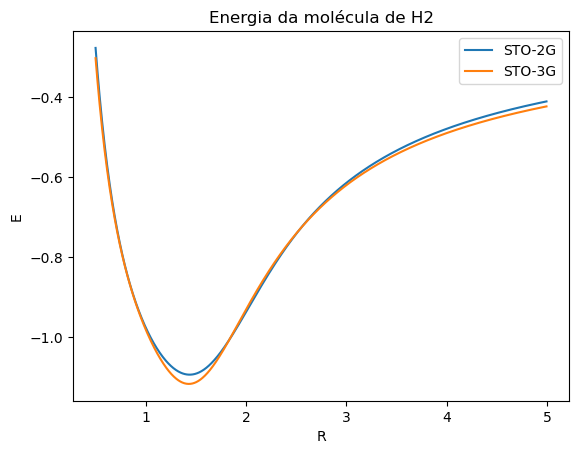

In [26]:
plt.plot(Rarray, Earray_2G, label = 'STO-2G')
plt.plot(Rarray, Earray_3G, label = 'STO-3G')
plt.legend(loc='upper right')
plt.xlabel('R')
plt.ylabel('E') 
plt.title('Energia da molécula de H2')

In [27]:
Ha = H_atom(R=[0.0, 0.0, 0.0])
Hb = H_atom(R=[1.4, 0.0, 0.0])

Ha.set_basis_set('STO-6G')
Hb.set_basis_set('STO-6G')

my_molecule = [Ha, Hb]

Earray_6G = np.zeros_like(Rarray)

for i, R in enumerate(Rarray):
    Ha.R = np.array([0.0, 0.0, 0.0])
    Hb.R = np.array([R, 0.0, 0.0])
    
    scf_energy, density_matrix = scf(my_molecule)
    Earray_6G[i] = scf_energy

Text(0.5, 1.0, 'Energia da molécula de H2')

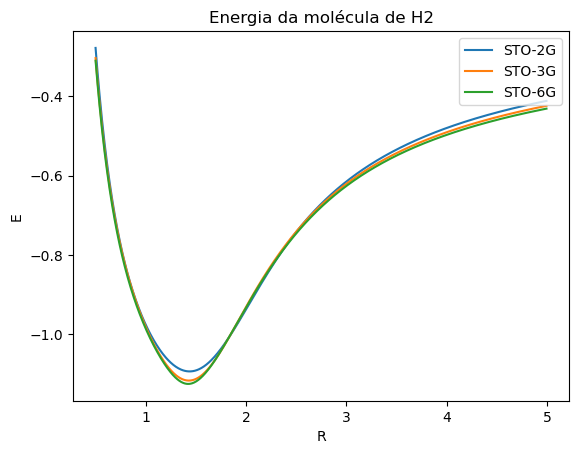

In [28]:
plt.plot(Rarray, Earray_2G, label = 'STO-2G')
plt.plot(Rarray, Earray_3G, label = 'STO-3G')
plt.plot(Rarray, Earray_6G, label = 'STO-6G')
plt.legend(loc='upper right')
plt.xlabel('R')
plt.ylabel('E') 
plt.title('Energia da molécula de H2')

In [29]:
Basislist = ['STO-2G', 'STO-3G', 'STO-6G']
Energylist = [Earray_2G, Earray_3G, Earray_6G]

In [30]:
for i, basis in enumerate(Basislist):
    print(f"Minimum energy for {basis}: {Energylist[i].min():.3f} at R = {Rarray[Energylist[i].argmin()]:.3f}")

Minimum energy for STO-2G: -1.094 at R = 1.435
Minimum energy for STO-3G: -1.117 at R = 1.430
Minimum energy for STO-6G: -1.126 at R = 1.425
